### NeuralProphet based prediction model to incorporate EIA pipeline data and Futures / Spot pricing data

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

In [2]:
# Values to set for use in dataframe sets
eia_shift = 1
future_shift = 0

In [3]:
# Disable logging messages unless there is an error
set_random_seed(42)
set_log_level("ERROR")
# eia_shift = 1
# future_shift = 0

### Create Base DF from eia pipeline info

In [4]:
df = pd.read_csv("data/all_eia_stock_sheet_latest.csv", sep=',')
df = df[['Date','WCESTUS1']]
df = df.dropna() 

# We have to change the columns to ds (date) and y in places of WCESTUS1 as that's what neuralprophet has to have
df = df.rename(columns={"Date": "ds", "WCESTUS1": "y"})
df["ds"] = pd.to_datetime(df["ds"])
df

,ds,y
0,1982-08-20,338764
1,1982-08-27,336138
2,1982-09-24,335586
3,1982-10-01,334786
4,1982-10-08,335260
...,...,...
2142,2023-10-20,421120
2143,2023-10-27,421893
2144,2023-11-03,435762
2145,2023-11-10,439354


### Plot just to do a quick looksy

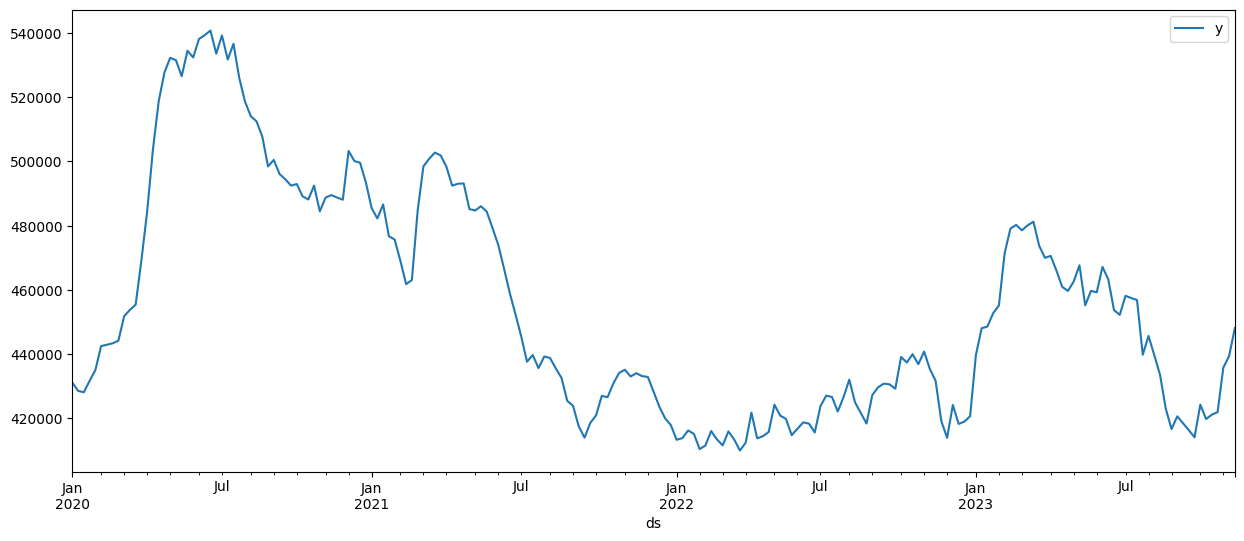

In [5]:
df = df.loc[(df["ds"] >= "01-01-2020")]
plt = df.plot(x="ds", y="y", figsize=(15, 6))

### Add in futures data from EIA

In [6]:
fut_prices_df = pd.read_csv("data/eia_futures_latest.csv", sep=",")
fut_prices_df.sort_index() #sort_values(by=['Date'], inplace=True)
fut_prices_df['Date'] = pd.to_datetime(fut_prices_df['Date'])
fut_prices_df.rename(columns={"Price":"FuturesPrice"}, inplace=True)
#fut_prices_df.drop(columns=['RCLC3', 'RCLC2', 'RCLC1'], axis=1, inplace=True)   
#fut_prices_df.drop(columns=['RCLC2', 'RCLC1'], axis=1, inplace=True)   
fut_prices_df.drop(columns=['RCLC1'], axis=1, inplace=True)   
fut_prices_df.dropna(inplace=True)
print(fut_prices_df.tail(-10))

           Date  RCLC2  RCLC3  RCLC4
103  1985-03-15  27.38  26.98  26.75
104  1985-03-22  27.96  27.50  27.23
105  1985-03-29  27.76  27.54  27.37
106  1985-04-05  28.31  28.09  27.91
107  1985-04-12  28.40  28.19  28.07
...         ...    ...    ...    ...
2117 2023-10-20  86.88  85.66  84.50
2118 2023-10-27  83.86  83.02  82.24
2119 2023-11-03  80.93  80.43  79.91
2120 2023-11-10  77.20  76.98  76.74
2121 2023-11-17  76.46  76.41  76.32

[2019 rows x 4 columns]


### Merge the pipleline and futures dataframes

In [7]:
main_df = pd.merge(df, fut_prices_df, left_on='ds', right_on='Date')
main_df.drop(columns=['Date'], inplace=True)
main_df

,ds,y,RCLC2,RCLC3,RCLC4
0,2020-01-03,431060,61.89,61.56,61.13
1,2020-01-10,428511,60.69,60.45,60.12
2,2020-01-17,428106,58.26,58.18,57.99
3,2020-01-24,431654,56.24,56.17,55.96
4,2020-01-31,435009,52.80,52.81,52.73
...,...,...,...,...,...
198,2023-10-20,421120,86.88,85.66,84.50
199,2023-10-27,421893,83.86,83.02,82.24
200,2023-11-03,435762,80.93,80.43,79.91
201,2023-11-10,439354,77.20,76.98,76.74


### Build the model and make forecast

In [13]:
m = NeuralProphet(
    n_changepoints=False,
    # Disable seasonality components
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    # Add the autogression
    n_lags=8,
    n_forecasts=1,
    #trainer_config=trainer_config
)
m.set_plotting_backend("matplotlib")
m.add_lagged_regressor('RCLC4')
m.add_lagged_regressor('RCLC3')
m.add_lagged_regressor('RCLC2')
metrics = m.fit(main_df)

ValueError: The parameter `plotting_backend` must be either 'plotly', 'plotly-resampler' or 'matplotlib'.

In [12]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,25098.833984,31690.128906,0.025603,0.0,0
1,21301.851562,28215.031250,0.020102,0.0,1
2,20960.964844,28207.687500,0.019139,0.0,2
3,21763.507812,27811.853516,0.019877,0.0,3
4,19488.416016,25244.496094,0.015903,0.0,4
...,...,...,...,...,...
365,4052.288818,5088.803711,0.000702,0.0,365
366,4231.039551,5312.354004,0.000737,0.0,366
367,4146.291992,5248.945801,0.000721,0.0,367
368,4138.510742,5270.065918,0.000731,0.0,368


### Plot data..most notable is the AR lag #'s

In [11]:
m.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'type': 'scatter',
              'uid': 'fcac4680-0ad4-45a2-8b4f-a9bca36895ef',
              'x': array([datetime.datetime(2020, 1, 3, 0, 0),
                          datetime.datetime(2023, 11, 17, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([487939.21875, 434438.84375]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              'name': 'AR',
              'type': 'bar',
              'uid': 'f4a907ca-2366-48c0-b5e0-de73f0c57f87',
              'x': array([8, 7, 6, 5, 4, 3, 2, 1]),
              'xaxis': 'x2',
              'y': array([0.01809608, 0.0544217 , 0.10996792, 0.087767  , 0.160268  , 0.10245391,
                          0.0012161 , 0.46580923], dtype=float32),
              'yaxis': 'y2'},
             {'marker': {'color': '#2

### See what the next weeks' forecast looks like

In [10]:

df_future = m.make_future_dataframe(main_df, n_historic_predictions=True, periods=1)
forecast = m.predict(df_future)

# Rename and clean up
forecast['+/-'] = (forecast['yhat1']-forecast['y']).round(0)
forecast = forecast.round(0)
forecast = forecast.fillna(0)

forecast = forecast.drop(['trend'], axis=1) 
forecast.rename(columns={"y": "Actual", "yhat1": "Prediction"}, inplace=True)
forecast = forecast.iloc[:,[0,1,2]]
forecast[-10::]

Predicting: 13it [00:00, ?it/s]

,ds,Actual,Prediction
194,2023-09-22,416287.0,416143.0
195,2023-09-29,414063.0,413988.0
196,2023-10-06,424239.0,416624.0
197,2023-10-13,419748.0,425671.0
198,2023-10-20,421120.0,419191.0
199,2023-10-27,421893.0,419533.0
200,2023-11-03,435762.0,425990.0
201,2023-11-10,439354.0,439300.0
202,2023-11-17,448054.0,441900.0
203,2023-11-24,0.0,449343.0
